In [1]:
from envs import SingleLaneEnv, BasisActionWrapper
from PPO import PPO
import time
import numpy as np
import torch

%matplotlib inline
import matplotlib.pyplot as plt

/Users/mat/Desktop/Cours X/3A/Research project/Code/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_env = SingleLaneEnv(T=20.0, dt = 0.02, macro_dt=0.4)
K_value = base_env.n_chunks
env = BasisActionWrapper(base_env, K=K_value)
env.n_chunks = K_value

In [3]:
ppo_env = PPO(env, [64], [64])
actor = ppo_env.actor
actor.load_state_dict(torch.load("actor_best8.pt"))
actor.eval()

Actor(
  (net): Sequential(
    (0): Linear(in_features=5001, out_features=64, bias=True)
    (1): ReLU()
  )
  (mu_head): Sequential(
    (0): Linear(in_features=64, out_features=50, bias=True)
    (1): Tanh()
  )
  (logstd_head): Linear(in_features=64, out_features=50, bias=True)
)

In [7]:
import numpy as np
import torch

def obs_to_tensor(obs: dict, device: torch.device) -> torch.Tensor:
    """Flatten obs = {'traj': (..), 't': scalar} -> (1, obs_dim) float32 tensor."""
    traj_flat = obs["traj"].reshape(-1).astype(np.float32)
    t = np.array([obs["t"]], dtype=np.float32)
    obs_vec = np.concatenate([traj_flat, t], axis=0)
    return torch.from_numpy(obs_vec).unsqueeze(0).to(device)  # (1, obs_dim)

@torch.no_grad()
def select_action(actor, obs_tensor, deterministic: bool = True):
    """Actor returns (mu, std). Return alpha as numpy 1D."""
    mu, std = actor(obs_tensor)          # shapes: (1, act_dim), (1, act_dim)
    if deterministic:
        a = mu
    else:
        dist = torch.distributions.Normal(mu, std)
        a = dist.sample()
    # Putting to scale
    a = 0.5 * (a + 1.0) * (env.env.u_max - env.env.u_min) + env.env.u_min
    return a.squeeze(0).cpu().numpy()    # (act_dim,)

def rollout_actor(env, actor, device, deterministic=True, render=True):
    actor.eval()
    n_steps = env.n_chunks

    (obs, info) = env.reset()
    print("Initial observation keys:", obs.keys())
    print("Trajectory shape:", obs["traj"].shape)
    print("Initial t:", obs["t"])

    for step in range(n_steps):
        obs_tensor = obs_to_tensor(obs, device)

        alpha = select_action(actor, obs_tensor, deterministic=deterministic)
        # ⚠️ IMPORTANT: only ONE step per loop
        (obs, _), reward, done, info = env.step(alpha)

        if render:
            # If your wrapper exposes Phi and base env is env.env
            env.env.render()

        print(
            f"step={step:02d} | "
            f"t={obs['t']:.3f} | "
            f"reward={reward: .3f} | "
            f"done={done}"
        )

        if done:
            break

    print("Done.")


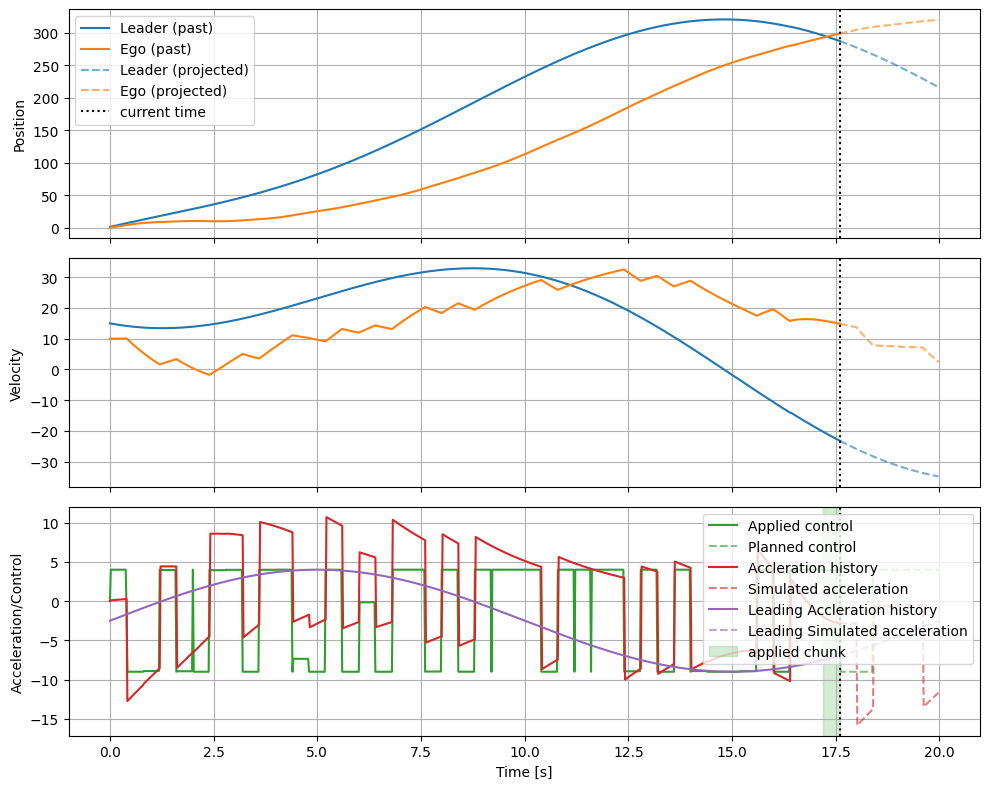

step=44 | t=17.600 | reward=-1000000.000 | done=True
Done.


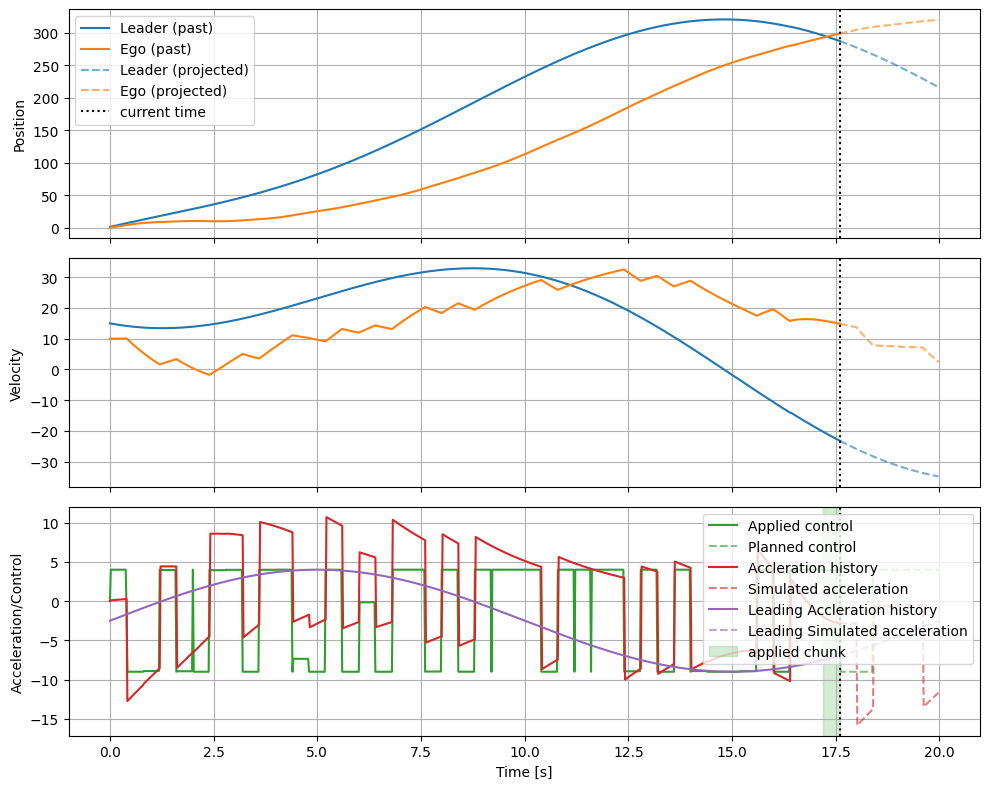

In [6]:
actor = ppo_env.actor
rollout_actor(env, actor, ppo_env.device, deterministic=False)